Just do it with keras
---

In [1]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

pi = np.pi

In [119]:
def simulate_trajectory(speed, azi, pitch, target, origin = np.array([0.,0.,0.]), timestep = 0.1, g = -10., distance_only = True):
    #get cartesian velocity from spherical coordinates
    velocity = speed*np.array([
        np.cos(azi)*np.cos(pitch),
        np.sin(azi)*np.cos(pitch),
        np.sin(pitch)
    ])
    acc = np.array([0.,0., g])
    history = [origin, origin+ velocity*timestep + (1/2)*acc*timestep**2]
    position = history[-1]
    distances = [np.linalg.norm(target - origin), np.linalg.norm(target - position)]
    distances = [np.linalg.norm(target - origin), np.linalg.norm(target - position)]
    #while the ball is above the ground, timestep to change position
    while position[2] >= 0:
#         print(history[-1])
        position = 2*history[-1] - history[-2] + acc*(timestep**2)
        distances.append(np.linalg.norm(target - position))
        history.append(position)
    if distance_only:
        return np.array(distances).min()
    else:
        return np.array(history)

In [120]:
simulate_trajectory(100,pi/23,pi/3,[200,200,100])

215.7568437385416

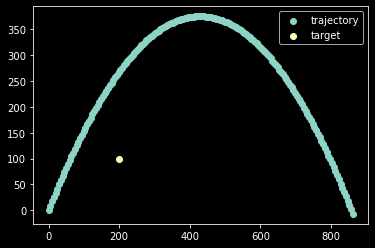

In [127]:
traj = simulate_trajectory(100,pi/23,pi/3,[200,200,100], distance_only = False)
plt.scatter(traj[:,0], traj[:,2], label = 'trajectory')
plt.scatter([200],[100], label = 'target')
plt.legend();

In [ ]:
plt.scatter()

for an actor-critic model, we need a model that estimates the loss given the state and policy output (critic) as well as a model producing the policy (actor).

In [94]:
class actor(keras.Model):
    def __init__(self, units, num_layers, num_outputs, output_activation = None):
        super().__init__()
        self.layer_list = []
        for layer in range(num_layers):
            self.layer_list.append(
                keras.layers.Dense(units = units,
                                  activation = 'relu',
                                  kernel_initializer = keras.initializers.he_normal,
                                  bias_initializer = keras.initializers.he_normal
                                  )
            )
        self.layer_list.append(
            keras.layers.Dense(num_outputs, activation = output_activation)
        )
        
    def call(self, x, training = True):
        x = x[:, tf.newaxis]
        for layer in self.layer_list:
            x = layer(x)
        return tf.squeeze(x, axis = 1)

class cannon:
    def __init__(self, max_speed, azimuth_limit = pi, pitch_limit = pi/2.):
        self.max_speed = max_speed
        self.azimuth_limit = azimuth_limit
        self.pitch_limit = pitch_limit
        
    def load(self, speed_frac, azi_frac, pitch_frac):
        return speed_frac*self.max_speed, azi_frac*self.azimuth_limit, pitch_frac*self.pitch_limit
        

In [95]:
my_Cannon = cannon(250)

In [98]:
#cannon just interprets intensity of inputs into speed and angles
my_Cannon.load(.2, -.3, .5)

(50.0, -0.9424777960769379, 0.7853981633974483)

In [72]:
#actor takes in three values (targetx, targety, targetz) and
#returns three values (speed, azimuth, pitch)
my_Actor = actor(64,2,3, 'sigmoid')

In [75]:
target_test_position = [240,403,2330]
test_policy = my_Actor(tf.constant([target_test_position]))
test_policy

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0., 0., 0.]], dtype=float32)>

In [76]:
#the critic is an actor with six inputs (three for target state,
#three for the actor's output) and 
#returns a single value estimating the closest the projectile gets
#to the target
my_Critic = actor(64,2,1)

In [77]:
test_policy[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>

In [78]:
critic_inputs = np.concatenate([target_test_position,test_policy[0]])
critic_inputs

array([ 240.,  403., 2330.,    0.,    0.,    0.])

In [79]:
my_Critic(tf.constant([critic_inputs]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1237.3301]], dtype=float32)>

In [113]:
test_speed, test_azi, test_pitch = test_policy[0] + np.array([0.8,pi/6,0.2])
test_speed, test_azi, test_pitch = my_Cannon.load(test_speed, test_azi, test_pitch)
simulate_trajectory(test_speed, test_azi, test_pitch, [12,535,23])

120.68407440185547

the actor wants to minimize the distance to the target
the critic wants to minimize the estimate of the distance

- actor:
    - get target location
    - return policy
    - get min distance of projectile to target as loss
- critic:
    - get target location, actor policy
    - return estimate of distance
    - get difference with real distance as loss
    
The data between training loops will look like:

In [ ]:
columns = ['targetx', 'targety', 'targetz', 'speed_policy', 'azi_policy', 'pitch_policy', 'min_distance']

The target positions will always be random.
At the beginning, the speed, azi, and pitch policies will be random. The min_distance will be calculated using simulate_trajectory() of these.

The critic will be trained on this data. It is essentially an estimator of simulate_trajectory().
The actor will feed answers to the critic, and get the critic's responses as losses. This will involve a custom training loop.